In [1]:
!pip install yahoofinancials
import yahoofinancials

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import date
from datetime import timedelta

from yahoofinancials import YahooFinancials

from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

import warnings
warnings.filterwarnings('ignore')

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=aa6d9b825c6b7f28b49408b88bfd974b6eb2f62482855a3ec504232dc042fcdd
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [2]:
end = '2021-08-03'
start = '2016-07-20'

stock_symbol = 'TCS.NS'

yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])

df = TCS.dropna()
df

,date,high,low,open,close,volume,adjclose,formatted_date
0,1468986300,1251.250000,1224.074951,1225.000000,1247.474976,2815252.0,1129.042114,2016-07-20
1,1469072700,1259.750000,1232.224976,1244.750000,1253.025024,2527148.0,1134.065430,2016-07-21
2,1469159100,1262.000000,1246.000000,1249.449951,1257.550049,1517216.0,1138.160645,2016-07-22
3,1469418300,1281.599976,1252.900024,1256.000000,1279.474976,1688796.0,1161.004517,2016-07-25
4,1469504700,1284.000000,1266.500000,1279.474976,1276.300049,2311290.0,1158.123901,2016-07-26
...,...,...,...,...,...,...,...,...
1238,1627357500,3210.000000,3161.149902,3200.000000,3182.949951,1121367.0,3182.949951,2021-07-27
1239,1627443900,3204.449951,3132.399902,3188.000000,3197.800049,1660654.0,3197.800049,2021-07-28
1240,1627530300,3225.449951,3190.300049,3200.250000,3195.800049,1731997.0,3195.800049,2021-07-29
1241,1627616700,3223.500000,3162.350098,3219.000000,3167.449951,2999943.0,3167.449951,2021-07-30


In [3]:
df = df[["formatted_date", "close"]]
df.rename(columns={"formatted_date": "ds", "close": "y"}, inplace=True)
df

,ds,y
0,2016-07-20,1247.474976
1,2016-07-21,1253.025024
2,2016-07-22,1257.550049
3,2016-07-25,1279.474976
4,2016-07-26,1276.300049
...,...,...
1238,2021-07-27,3182.949951
1239,2021-07-28,3197.800049
1240,2021-07-29,3195.800049
1241,2021-07-30,3167.449951


In [4]:
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

Train Test split

In [5]:
cut_date = '2021-06-19'
mask1 = (df['ds'] <= cut_date)
mask2 = (df['ds'] > cut_date)

X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1211, 2)
test shape (30, 2)


In [6]:
X_tst.tail

<bound method NDFrame.tail of              ds            y
1213 2021-06-21  3273.100098
1214 2021-06-22  3301.199951
1215 2021-06-23  3261.399902
1216 2021-06-24  3373.600098
1217 2021-06-25  3380.800049
1218 2021-06-28  3336.750000
1219 2021-06-29  3340.850098
1220 2021-06-30  3345.750000
1221 2021-07-01  3341.500000
1222 2021-07-02  3325.449951
1223 2021-07-05  3321.000000
1224 2021-07-06  3262.300049
1225 2021-07-07  3274.949951
1226 2021-07-08  3258.500000
1227 2021-07-09  3208.149902
1228 2021-07-12  3193.100098
1229 2021-07-13  3187.550049
1230 2021-07-14  3214.550049
1231 2021-07-15  3202.949951
1232 2021-07-16  3194.800049
1233 2021-07-19  3184.600098
1234 2021-07-20  3205.800049
1235 2021-07-22  3216.350098
1236 2021-07-23  3212.850098
1237 2021-07-26  3197.550049
1238 2021-07-27  3182.949951
1239 2021-07-28  3197.800049
1240 2021-07-29  3195.800049
1241 2021-07-30  3167.449951
1242 2021-08-02  3219.399902>

Install library

In [7]:
!pip install fbprophet
from fbprophet import Prophet


Model Building

In [8]:
import tensorflow as tf
tf.random.set_seed(seed=1)
model =Prophet(changepoint_prior_scale= 0.2, seasonality_prior_scale=0.01, seasonality_mode='multiplicative',changepoint_range=0.9) 
model.fit(X_tr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = model.make_future_dataframe(periods=31, freq='B')
forecast = model.predict(future)

In [10]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,1346.040135,1249.451964,1409.941015,1346.040135,1346.040135,-0.012959,-0.012959,-0.012959,0.002963,0.002963,0.002963,-0.015922,-0.015922,-0.015922,0.0,0.0,0.0,1328.596362
1,2016-07-21,1344.354348,1246.627779,1404.058111,1344.354348,1344.354348,-0.013528,-0.013528,-0.013528,0.002202,0.002202,0.002202,-0.015730,-0.015730,-0.015730,0.0,0.0,0.0,1326.167972
2,2016-07-22,1342.668562,1242.947161,1408.145555,1342.668562,1342.668562,-0.015095,-0.015095,-0.015095,0.000437,0.000437,0.000437,-0.015531,-0.015531,-0.015531,0.0,0.0,0.0,1322.401035
3,2016-07-25,1337.611201,1241.154004,1400.784689,1337.611201,1337.611201,-0.013098,-0.013098,-0.013098,0.001876,0.001876,0.001876,-0.014974,-0.014974,-0.014974,0.0,0.0,0.0,1320.091274
4,2016-07-26,1335.925414,1237.591055,1400.367786,1335.925414,1335.925414,-0.012526,-0.012526,-0.012526,0.002293,0.002293,0.002293,-0.014819,-0.014819,-0.014819,0.0,0.0,0.0,1319.191660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,2021-07-27,3313.276590,3181.559738,3362.348476,3289.343566,3337.410549,-0.012425,-0.012425,-0.012425,0.002293,0.002293,0.002293,-0.014719,-0.014719,-0.014719,0.0,0.0,0.0,3272.108830
1238,2021-07-28,3315.272968,3188.659624,3364.593905,3290.597441,3340.902965,-0.011644,-0.011644,-0.011644,0.002963,0.002963,0.002963,-0.014606,-0.014606,-0.014606,0.0,0.0,0.0,3276.671268
1239,2021-07-29,3317.269346,3178.391141,3363.645053,3291.368988,3343.954197,-0.012319,-0.012319,-0.012319,0.002202,0.002202,0.002202,-0.014521,-0.014521,-0.014521,0.0,0.0,0.0,3276.402771
1240,2021-07-30,3319.265724,3185.287485,3365.672541,3290.766126,3347.824967,-0.014028,-0.014028,-0.014028,0.000437,0.000437,0.000437,-0.014464,-0.014464,-0.014464,0.0,0.0,0.0,3272.704061


Actual vs Prediction

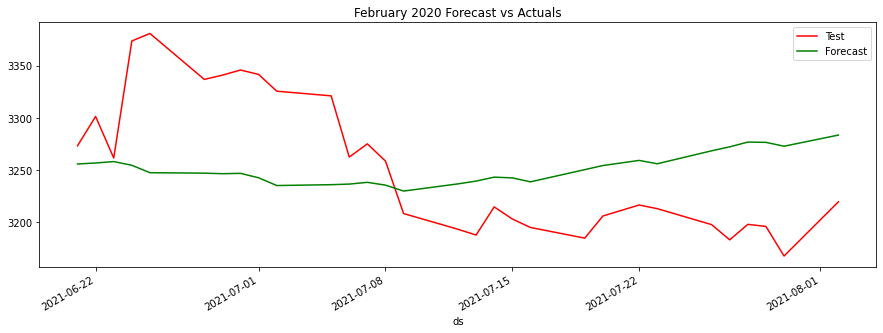

In [11]:
X_tst_forecast = model.predict(X_tst)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

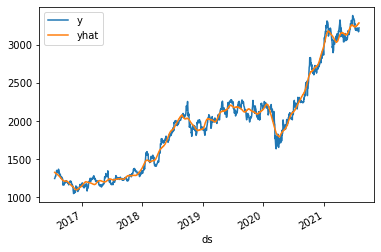

In [13]:
pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

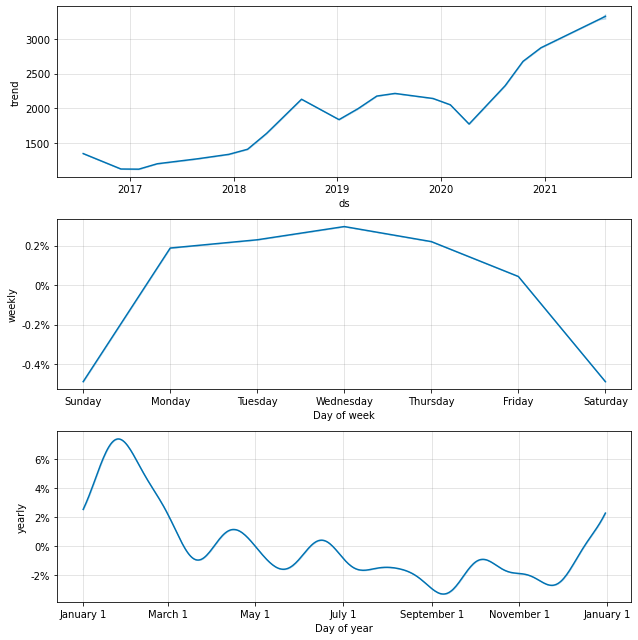

In [14]:
fig2 = model.plot_components(forecast)

MSE

In [ ]:
from sklearn.metrics import mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_squared_error(X_tst['y'],X_tst_forecast['yhat'])


4981.445478080422

MAPE

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 1.9175


Next 30 Days Prediction

In [ ]:
df

In [ ]:
#make_future_dataframe(m, periods, freq = "day", include_history = TRUE)

future = model.make_future_dataframe(periods=30)
forecast_30 = model.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,1346.040135,1248.363585,1410.885796,1346.040135,1346.040135,-0.012959,-0.012959,-0.012959,0.002963,0.002963,0.002963,-0.015922,-0.015922,-0.015922,0.0,0.0,0.0,1328.596362
1,2016-07-21,1344.354348,1242.761711,1408.752518,1344.354348,1344.354348,-0.013528,-0.013528,-0.013528,0.002202,0.002202,0.002202,-0.015730,-0.015730,-0.015730,0.0,0.0,0.0,1326.167972
2,2016-07-22,1342.668562,1241.680126,1400.586860,1342.668562,1342.668562,-0.015095,-0.015095,-0.015095,0.000437,0.000437,0.000437,-0.015531,-0.015531,-0.015531,0.0,0.0,0.0,1322.401035
3,2016-07-25,1337.611201,1234.668400,1398.556648,1337.611201,1337.611201,-0.013098,-0.013098,-0.013098,0.001876,0.001876,0.001876,-0.014974,-0.014974,-0.014974,0.0,0.0,0.0,1320.091274
4,2016-07-26,1335.925414,1241.440036,1402.158748,1335.925414,1335.925414,-0.012526,-0.012526,-0.012526,0.002293,0.002293,0.002293,-0.014819,-0.014819,-0.014819,0.0,0.0,0.0,1319.191660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2021-07-14,3287.323675,3159.558771,3321.271494,3282.986213,3293.385373,-0.013469,-0.013469,-0.013469,0.002963,0.002963,0.002963,-0.016431,-0.016431,-0.016431,0.0,0.0,0.0,3243.047754
1237,2021-07-15,3289.320053,3161.150595,3326.810136,3284.059385,3296.041876,-0.014280,-0.014280,-0.014280,0.002202,0.002202,0.002202,-0.016481,-0.016481,-0.016481,0.0,0.0,0.0,3242.349193
1238,2021-07-16,3291.316431,3152.578507,3323.317053,3285.063238,3299.998111,-0.016032,-0.016032,-0.016032,0.000437,0.000437,0.000437,-0.016468,-0.016468,-0.016468,0.0,0.0,0.0,3238.550833
1239,2021-07-17,3293.312809,3136.405729,3306.518686,3285.702838,3302.866970,-0.021286,-0.021286,-0.021286,-0.004885,-0.004885,-0.004885,-0.016401,-0.016401,-0.016401,0.0,0.0,0.0,3223.212026


Train Test split

In [15]:
cut_date = '2021-07-19'
mask1 = (df['ds'] <= cut_date)
mask2 = (df['ds'] > cut_date)

X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (1232, 2)
test shape (9, 2)


In [16]:
import tensorflow as tf
tf.random.set_seed(seed=1)
model =Prophet(changepoint_prior_scale= 0.4, n_changepoints=100, seasonality_mode='multiplicative') 
model.fit(X_tr)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
future = model.make_future_dataframe(periods=9, freq='C')
forecast = model.predict(future)


In [18]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,303.349020,1225.798181,1322.618390,303.349020,303.349020,3.207339,3.207339,3.207339,3.447244,3.447244,3.447244,-0.239904,-0.239904,-0.239904,0.0,0.0,0.0,1276.292291
1,2016-07-21,304.469032,1234.232658,1328.568195,304.469032,304.469032,3.201199,3.201199,3.201199,3.445360,3.445360,3.445360,-0.244160,-0.244160,-0.244160,0.0,0.0,0.0,1279.135059
2,2016-07-22,305.589044,1230.860952,1332.604176,305.589044,305.589044,3.191379,3.191379,3.191379,3.439400,3.439400,3.439400,-0.248021,-0.248021,-0.248021,0.0,0.0,0.0,1280.839575
3,2016-07-25,308.949081,1245.422649,1344.366038,308.949081,308.949081,3.184944,3.184944,3.184944,3.442782,3.442782,3.442782,-0.257838,-0.257838,-0.257838,0.0,0.0,0.0,1292.934738
4,2016-07-26,310.069093,1247.759575,1346.152725,310.069093,310.069093,3.185640,3.185640,3.185640,3.446371,3.446371,3.446371,-0.260731,-0.260731,-0.260731,0.0,0.0,0.0,1297.837503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,2021-07-26,768.620507,3161.222746,3264.645882,767.587472,770.362805,3.182764,3.182764,3.182764,3.442782,3.442782,3.442782,-0.260018,-0.260018,-0.260018,0.0,0.0,0.0,3214.958076
1237,2021-07-27,769.258983,3168.411493,3271.739886,767.457517,771.793853,3.183529,3.183529,3.183529,3.446371,3.446371,3.446371,-0.262841,-0.262841,-0.262841,0.0,0.0,0.0,3218.217588
1238,2021-07-28,769.897459,3165.479428,3271.954318,767.118279,773.645090,3.181622,3.181622,3.181622,3.447244,3.447244,3.447244,-0.265622,-0.265622,-0.265622,0.0,0.0,0.0,3219.420223
1239,2021-07-29,770.535936,3162.401029,3274.168250,766.828287,775.320612,3.176947,3.176947,3.176947,3.445360,3.445360,3.445360,-0.268413,-0.268413,-0.268413,0.0,0.0,0.0,3218.487409


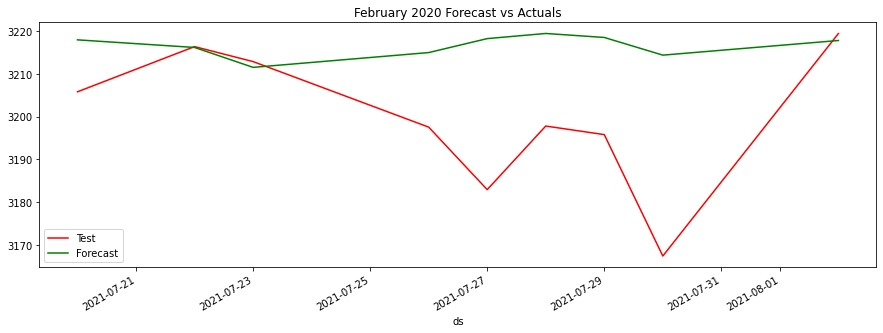

In [ ]:
X_tst_forecast = model.predict(X_tst)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

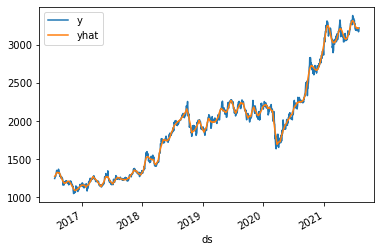

In [19]:
pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

In [ ]:
from sklearn.metrics import mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_squared_error(X_tst['y'],X_tst_forecast['yhat'])


542.3485164244926

In [ ]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 0.5551


In [ ]:
future = model.make_future_dataframe(periods=30)
forecast_30 = model.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-07-20,303.349020,1230.498660,1327.071071,303.349020,303.349020,3.207339,3.207339,3.207339,3.447244,3.447244,3.447244,-0.239904,-0.239904,-0.239904,0.0,0.0,0.0,1276.292291
1,2016-07-21,304.469032,1228.914580,1328.455234,304.469032,304.469032,3.201199,3.201199,3.201199,3.445360,3.445360,3.445360,-0.244160,-0.244160,-0.244160,0.0,0.0,0.0,1279.135059
2,2016-07-22,305.589044,1228.471055,1329.937401,305.589044,305.589044,3.191379,3.191379,3.191379,3.439400,3.439400,3.439400,-0.248021,-0.248021,-0.248021,0.0,0.0,0.0,1280.839575
3,2016-07-25,308.949081,1242.349390,1342.487318,308.949081,308.949081,3.184944,3.184944,3.184944,3.442782,3.442782,3.442782,-0.257838,-0.257838,-0.257838,0.0,0.0,0.0,1292.934738
4,2016-07-26,310.069093,1245.636942,1344.844477,310.069093,310.069093,3.185640,3.185640,3.185640,3.446371,3.446371,3.446371,-0.260731,-0.260731,-0.260731,0.0,0.0,0.0,1297.837503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2021-08-14,780.751555,-6421.877161,-5971.069407,750.909024,808.324887,-8.942196,-8.942196,-8.942196,-8.610578,-8.610578,-8.610578,-0.331618,-0.331618,-0.331618,0.0,0.0,0.0,-6200.882105
1258,2021-08-15,781.390032,-6438.777998,-5953.737572,749.450792,810.337155,-8.946717,-8.946717,-8.946717,-8.610578,-8.610578,-8.610578,-0.336139,-0.336139,-0.336139,0.0,0.0,0.0,-6209.485768
1259,2021-08-16,782.028508,3067.914227,3348.573112,748.473705,812.484250,3.102259,3.102259,3.102259,3.442782,3.442782,3.442782,-0.340523,-0.340523,-0.340523,0.0,0.0,0.0,3208.083541
1260,2021-08-17,782.666984,3064.377729,3352.318838,747.292345,815.255212,3.101645,3.101645,3.101645,3.446371,3.446371,3.446371,-0.344726,-0.344726,-0.344726,0.0,0.0,0.0,3210.221826
